Using the equations of motion and the trivial derivative equations:

theta defined as the rotation along the positive y direction

$
\begin{aligned}
& F_x = \dot{v_x}m = (u_1 + u_2 + u_3) \sin(\theta)\\
& F_z = \dot{v_z}m = (u_1 + u_2 + u_3)\cos (\theta) - mg\\
& M_y = (u_3-u_1)L_{ca}\\
& \\
& \dot p_x = v_x\\
& \dot p_z = v_z\\
& \dot \theta = q
\end{aligned}
$

Rearranging gives the following state space equations:

$
x = 
\begin{bmatrix}
p_x\\
p_z\\
\theta\\
v_x\\
v_z\\
q
\end{bmatrix}
$

$
\dot x = 
\begin{bmatrix}
v_x\\
v_z\\
q\\
\frac{(u_1 + u_2 + u_3)\sin(\theta)}{m}\\
\frac{(u_1 + u_2 + u_3)\cos \theta}{m} - g\\
\frac{(u_3-u_1)L_{ca}}{I}
\end{bmatrix}
$

Let's try to implement this in rockit

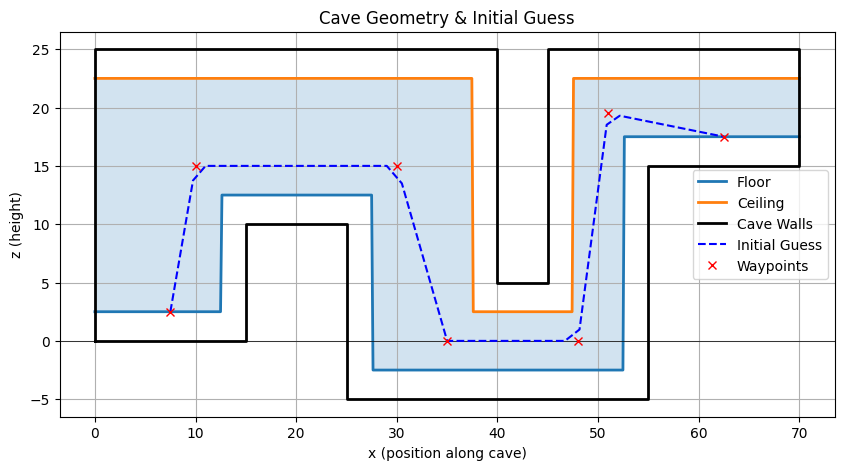

Found warm start file: moonlander_solution.npz. Loading...
Warm start guesses set (resampled to N=100).
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4506
Number of nonzeros in inequality constraint Jacobian.:      910
Number of nonzeros in Lagrangian Hessian.............:     2107

Total number of variables............................:      907
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:      708
        inequality constraints with only lower bounds:      102
   inequality constraints with lower and upper bounds:      303
        inequality constraints with only upper bounds:      303

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg

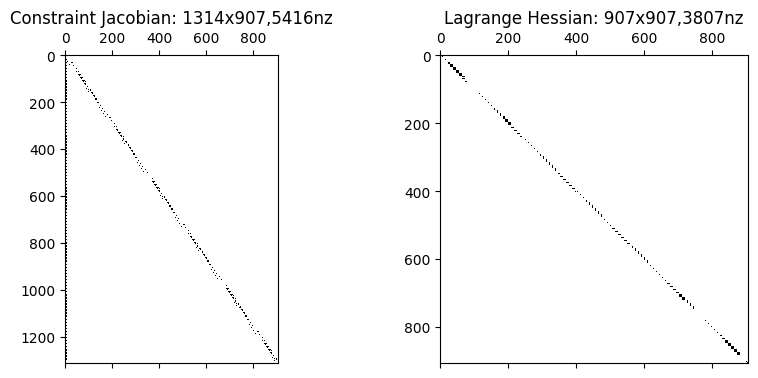

In [69]:
from rockit import *
import casadi as cs
from numpy import sin, pi
import matplotlib.pyplot as plt
import numpy as np

PLOT_CAVE_WALL_CONSTRAINTS = True
EXPORT_STATES_FOR_WARM_START = False
USE_SOLVED_RUN_AS_WARM_START = True


ocp = Ocp(T=FreeTime(35.0))
N_steps = 100 # Define N here to use it for linspace

# Define constants
g = 1.625 # m/s^2
m = 4280.0 # kg
L_ca = 2.11 # m
I = 1000 # kg*m^2
F_max_1 = 2500 # N
F_max_2 = 10000 # N (center one is stronger)
F_max_3 = 2500 # N

# Fuel consumption is ~ force², center engine is twice as efficient
consumption_coeff_1 = 1.0
consumption_coeff_2 = 0.5
consumption_coeff_3 = 1.0

# Define Cave Polygon
cave_x = [0, 15, 15, 25, 25, 55, 55, 70, 70, 45, 45, 40, 40, 0, 0]
cave_z = [0, 0, 10, 10, -5, -5, 15, 15, 25, 25, 5, 5, 25, 25, 0]

# define states
p_x = ocp.state()   # position x
p_z = ocp.state()   # position z
theta = ocp.state() # angle
v_x = ocp.state()   # velocity x
v_z = ocp.state()   # velocity z
q = ocp.state()     # angular velocity

# define controls
u_1 = ocp.control() # thrust engine 1
u_2 = ocp.control() # thrust engine 2
u_3 = ocp.control() # thrust engine 3

# define ODEs
ocp.set_der(p_x, v_x)
ocp.set_der(p_z, v_z)
ocp.set_der(theta, q)
ocp.set_der(v_x, (u_1 + u_2 + u_3) * cs.sin(theta) / m)
ocp.set_der(v_z, (u_1 + u_2 + u_3) * cs.cos(theta) / m - g)
ocp.set_der(q, (L_ca * (u_3 - u_1)) / I)

# Lagrange objective
ocp.add_objective(10*ocp.T)
# penalty on q angular velocity
# ocp.add_objective(ocp.integral(q**2))
#ocp.add_objective(ocp.integral(p_z**2))
ocp.add_objective(ocp.integral(400*(theta**2)))
#ocp.add_objective(ocp.integral(0.5*q**2))

# Path constraints
ocp.subject_to(0 <= (u_1 <= F_max_1))
ocp.subject_to(0 <= (u_2 <= F_max_2))
ocp.subject_to(0 <= (u_3 <= F_max_3))

# Cave constraints
lander_radius = 2.5

# Floor constraints (piecewise function for the cave floor)
# 0-15: z=0 | 15-25: z=10 | 25-55: z=-5 | 55-70: z=15
# floor_level = cs.if_else(p_x <= 15-lander_radius, 0,
#                 cs.if_else(p_x <= 25 + lander_radius, 10,
#                     cs.if_else(p_x <= 55 - lander_radius, -5, 15)))
# ocp.subject_to(p_z >= floor_level + lander_radius)

# Walls (otherwise the lander will fly out of the cave and not find a good solution)
ocp.subject_to(p_x >= 0 + lander_radius)
ocp.subject_to(p_x <= 70 - lander_radius)

# Floor function
floor_level = cs.if_else(p_x <= 15-lander_radius, 0,
                cs.if_else(p_x <= 25 + lander_radius, 10,
                    cs.if_else(p_x <= 55 - lander_radius, -5, 15)))
ocp.subject_to(p_z >= floor_level + lander_radius)

# Ceiling function
ceiling_level = cs.if_else(p_x <= 40-lander_radius, 25,
                cs.if_else(p_x <= 45 + lander_radius, 5, 25))
ocp.subject_to(p_z <= ceiling_level - lander_radius)


if not USE_SOLVED_RUN_AS_WARM_START:
    # Plot initial guide to reach the target
    waypoints_x = [7.5, 10, 30.0, 35.0, 48.0, 51.0, 62.5]
    waypoints_z = [2.5, 15.0, 15.0, 0.0, 0.0, 19.5, 17.5]

    # 2. Interpolate these points to match the discretization grid
    # States in MultipleShooting are typically defined at N+1 points
    t_waypoints = np.linspace(0, 1, len(waypoints_x))
    t_grid = np.linspace(0, 1, N_steps + 1)

    p_x_guess = np.interp(t_grid, t_waypoints, waypoints_x)
    p_z_guess = np.interp(t_grid, t_waypoints, waypoints_z)

    # 3. Set the initial guesses on the OCP object
    ocp.set_initial(p_x, p_x_guess)
    ocp.set_initial(p_z, p_z_guess)

    # Also provide a guess for the main engine to hover (counteract gravity)
    ocp.set_initial(u_2, m * g)


if PLOT_CAVE_WALL_CONSTRAINTS:
    # Define CasADi variable
    px = cs.MX.sym('px')

    # Floor function
    floor_level = cs.if_else(px <= 15-lander_radius, 0,
                    cs.if_else(px <= 25 + lander_radius, 10,
                        cs.if_else(px <= 55 - lander_radius, -5, 15))) + lander_radius

    # Ceiling function
    ceiling_level = cs.if_else(px <= 40-lander_radius, 25,
                    cs.if_else(px <= 45 + lander_radius, 5, 25)) - lander_radius

    # Turn into callable functions
    floor_fun = cs.Function('floor_fun', [px], [floor_level])
    ceiling_fun = cs.Function('ceiling_fun', [px], [ceiling_level])

    # Sample grid
    xs = np.linspace(0, 70, 500)
    floor_vals = np.array([floor_fun(x).full().item() for x in xs], dtype=float)
    ceiling_vals = np.array([ceiling_fun(x).full().item() for x in xs], dtype=float)

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(xs, floor_vals, label="Floor", lw=2)
    plt.plot(xs, ceiling_vals, label="Ceiling", lw=2)
    plt.fill_between(xs, floor_vals, ceiling_vals, alpha=0.2)  # cave walls
    plt.axhline(0, color='black', linewidth=0.5)
    plt.plot(cave_x, cave_z, 'k-', linewidth=2, label='Cave Walls')

    # Plot the initial guess
    plt.plot(p_x_guess, p_z_guess, 'b--', label='Initial Guess')
    plt.plot(waypoints_x, waypoints_z, 'rx', label='Waypoints')

    plt.xlabel("x (position along cave)")
    plt.ylabel("z (height)")
    plt.title("Cave Geometry & Initial Guess")
    plt.grid(True)
    plt.legend()
    plt.show()

# Initial constraints
ocp.subject_to(ocp.at_t0(p_x)==7.5)
ocp.subject_to(ocp.at_t0(p_z)==2.5)
ocp.subject_to(ocp.at_t0(v_x)==0)
ocp.subject_to(ocp.at_t0(v_z)==0)
ocp.subject_to(ocp.at_t0(theta)==0)
ocp.subject_to(ocp.at_t0(v_z)==0)


# End constraints as part of the objective -> easier to solve
final_x = 62.5
final_z = 17.5
# Add soft constraints (Mayer objective terms)
# Use a high weight to prioritize reaching the target
w_terminal = 100
ocp.add_objective(w_terminal * (ocp.at_tf(p_x) - final_x)**2)
ocp.add_objective(w_terminal * (ocp.at_tf(p_z) - final_z)**2)
ocp.add_objective(w_terminal * (ocp.at_tf(v_x))**2)
ocp.add_objective(w_terminal * (ocp.at_tf(v_z))**2)
ocp.add_objective(w_terminal * 10 * (ocp.at_tf(theta))**2)
ocp.add_objective(w_terminal * 100 * (ocp.at_tf(q))**2)

# Set initial guesss:
# ocp.set_initial(p_x, np.linspace(7.5, 62.5, N_steps))
# ocp.set_initial(p_z, np.linspace(2.5, 17.5, N_steps))
# ocp.set_initial(u_2, m*g/2) # Guess hovering thrust

# Pick a solver for the discretized NLP
ocp.solver('ipopt', {'ipopt': {"max_iter": 500}})

# Choose a solution method to transcribe the OCP into an NLP (discretization)
ocp.method(MultipleShooting(N=N_steps, M=1, intg='rk'))

# Visualize the OCP
ocp.spy()

# Warm start from previous solution if available
if USE_SOLVED_RUN_AS_WARM_START:
    import os
    warm_start_file = 'moonlander_solution.npz'
    if os.path.exists(warm_start_file):
        print(f"Found warm start file: {warm_start_file}. Loading...")
        try:
            data = np.load(warm_start_file)
            t_saved = data['t']
            
            def resample(x_old, n_new):
                # Resample x_old (defined on t_saved) to new grid with n_new points
                t_new = np.linspace(t_saved[0], t_saved[-1], n_new)
                return np.interp(t_new, t_saved, x_old)

            # States typically need N+1 points
            ocp.set_initial(p_x, resample(data['p_x'], N_steps + 1))
            ocp.set_initial(p_z, resample(data['p_z'], N_steps + 1))
            ocp.set_initial(theta, resample(data['theta'], N_steps + 1))
            ocp.set_initial(v_x, resample(data['v_x'], N_steps + 1))
            ocp.set_initial(v_z, resample(data['v_z'], N_steps + 1))
            ocp.set_initial(q, resample(data['q'], N_steps + 1))
            
            # Controls typically need N points (piecewise constant) or N+1 (if linear)
            # Providing N+1 points is generally safe for set_initial
            ocp.set_initial(u_1, resample(data['u_1'], N_steps + 1))
            ocp.set_initial(u_2, resample(data['u_2'], N_steps + 1))
            ocp.set_initial(u_3, resample(data['u_3'], N_steps + 1))
            
            print(f"Warm start guesses set (resampled to N={N_steps}).")
        except Exception as e:
            print(f"Failed to load warm start: {e}")

# solve
try:
    sol = ocp.solve()
    print("Solver succeeded.")
except Exception as e:
    print("\n=== Solver FAILED, using debug values ===")
    print("Failure message:", e)

    opti = ocp._method.opti    # access internal Opti instance

    class FailedSolution:
        """Wraps Opti debug values so sol.sample(...) still works."""
        def __init__(self, ocp, opti):
            self.ocp = ocp
            self.opti = opti

        def sample(self, expr, grid="control", refine=1):
            # Use the OCP's symbolic sampling to get expressions for time and value
            t_sym, x_sym = self.ocp.sample(expr, grid=grid, refine=refine)
            
            # Evaluate these expressions using the current debug values from the optimizer
            t_val = self.opti.debug.value(t_sym)
            x_val = self.opti.debug.value(x_sym)

            # Convert to numpy arrays (Critical for matplotlib!)
            if hasattr(t_val, 'full'): t_val = t_val.full().flatten()
            if hasattr(x_val, 'full'): x_val = x_val.full().flatten()
            
            return t_val, x_val

    sol = FailedSolution(ocp, opti)

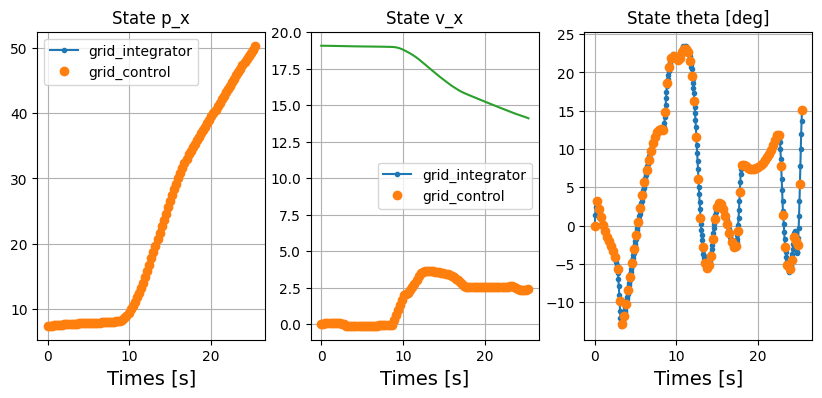

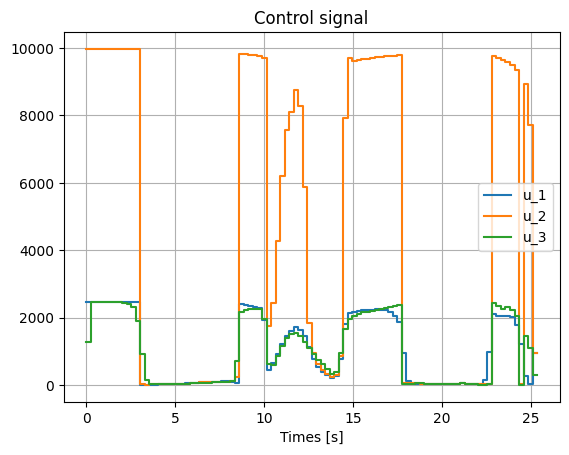

In [70]:
## Make figures and do post-processing
from pylab import *

# Post-processing
tsa, pa_x = sol.sample(p_x, grid='control')
tsa, va_x = sol.sample(v_x, grid='control')
# for z direction
tsa, pa_z = sol.sample(p_z, grid='control')
tsa, va_z = sol.sample(v_z, grid='control')
# for theta
tsa, theta_a = sol.sample(theta, grid='control')
tsa, q_a = sol.sample(q, grid='control')

tsb, pb_x = sol.sample(p_x, grid='integrator', refine=5)
tsb, vb_x = sol.sample(v_x, grid='integrator', refine=5)
# for z direction
tsb, pb_z = sol.sample(p_z, grid='integrator', refine=5)
tsb, vb_z = sol.sample(v_z, grid='integrator', refine=5)
# for theta
tsb, theta_b = sol.sample(theta, grid='integrator', refine=5)
tsb, q_b = sol.sample(q, grid='integrator', refine=5)



figure(figsize=(10, 4))
subplot(1, 3, 1)
plot(tsb, pb_x, '.-')
plot(tsa, pa_x, 'o')
xlabel("Times [s]", fontsize=14)
legend(['grid_integrator', 'grid_control'])
grid(True)
title('State p_x')

subplot(1, 3, 2)
plot(tsb, vb_x, '.-')
plot(tsa, va_x, 'o')
plot(tsb, 20 - 10*sin(pi*pb_x/250))
legend(['grid_integrator', 'grid_control'])
xlabel("Times [s]", fontsize=14)
title('State v_x')
grid(True)

subplot(1, 3, 3)
plot(tsb, np.rad2deg(theta_b), '.-')
plot(tsa, np.rad2deg(theta_a), 'o')
xlabel("Times [s]", fontsize=14)
title('State theta [deg]')
grid(True)

tsol, usol_1 = sol.sample(u_1, grid='control')
tsol, usol_2 = sol.sample(u_2, grid='control')
tsol, usol_3 = sol.sample(u_3, grid='control')

figure()
step(tsol,usol_1,where='post')
step(tsol,usol_2,where='post')
step(tsol,usol_3,where='post')
title("Control signal")
xlabel("Times [s]")
legend(['u_1','u_2','u_3'])
grid(True)

plt.show(block=True)

In [71]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Sample controls on the same grid as states for animation
tsb, ub_1 = sol.sample(u_1, grid='integrator', refine=5)
tsb, ub_2 = sol.sample(u_2, grid='integrator', refine=5)
tsb, ub_3 = sol.sample(u_3, grid='integrator', refine=5)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
ax.grid(True)
ax.set_xlabel('X [m]')
ax.set_ylabel('Z [m]')
ax.set_title('Moonlander Animation')
# Plot Cave
ax.plot(cave_x, cave_z, 'k-', linewidth=2, label='Cave Walls')

# Set limits based on trajectory
x_min, x_max = np.min(pb_x), np.max(pb_x)
z_min, z_max = np.min(pb_z), np.max(pb_z)
margin = 5
# minimum of cave dimesions
ax.set_xlim(min(cave_x) - margin, max(cave_x) + margin)
ax.set_ylim(min(cave_z) - margin, max(cave_z) + margin)

# Elements to animate
lander_body, = ax.plot([], [], 'k-', linewidth=2)
trajectory, = ax.plot([], [], 'b--', alpha=0.5)
# Thrusters (lines)
thrust_1, = ax.plot([], [], 'r-', linewidth=2)
thrust_2, = ax.plot([], [], 'r-', linewidth=2)
thrust_3, = ax.plot([], [], 'r-', linewidth=2)

time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

# Lander geometry
w = 4  # width
h = 2  # height
# Define a rectangle centered at 0,0
body_pts = np.array([
    [-w/2, -h/2],
    [w/2, -h/2],
    [w/2, h/2],
    [-w/2, h/2],
    [-w/2, -h/2]
])

# Thruster positions relative to center
try:
    l_dist = L_ca
except NameError:
    l_dist = 2.11

thruster_origins = np.array([
    [-l_dist, -h/2], # u1
    [0, -h/2],       # u2
    [l_dist, -h/2]   # u3
])

# Scaling factor for thrust visualization
max_thrust = max(np.max(ub_1), np.max(ub_2), np.max(ub_3))
scale = 5.0 / max_thrust if max_thrust > 0 else 1.0

def update(frame):
    # Get current state
    x = pb_x[frame]
    z = pb_z[frame]
    th = theta_b[frame]
    t = tsb[frame]
    
    # Rotation matrix
    # Physics: Force ~ [sin(th), cos(th)]. 
    # We want Body Up [0,1] to align with Force.
    # R @ [0,1] = [sin, cos] => R = [[cos, sin], [-sin, cos]]
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, s], [-s, c]])
    
    # Transform body points
    current_body = (R @ body_pts.T).T + np.array([x, z])
    lander_body.set_data(current_body[:, 0], current_body[:, 1])
    
    # Trajectory
    trajectory.set_data(pb_x[:frame+1], pb_z[:frame+1])
    
    # Thrusters
    u = [ub_1[frame], ub_2[frame], ub_3[frame]]
    thrust_lines = [thrust_1, thrust_2, thrust_3]
    
    for i in range(3):
        if u[i] > 1e-3: # Only draw if active
            # Start point (relative)
            p0_rel = thruster_origins[i]
            # End point (relative) - pointing down (negative y in local frame)
            # Length proportional to thrust
            length = u[i] * scale
            p1_rel = p0_rel + np.array([0, -length])
            
            # Transform to global
            p0 = (R @ p0_rel) + np.array([x, z])
            p1 = (R @ p1_rel) + np.array([x, z])
            
            thrust_lines[i].set_data([p0[0], p1[0]], [p0[1], p1[1]])
        else:
            thrust_lines[i].set_data([], [])

    time_text.set_text(f'Time: {t:.2f} s')
    
    return lander_body, trajectory, thrust_1, thrust_2, thrust_3, time_text

# Create animation
dt = tsb[1] - tsb[0] if len(tsb) > 1 else 0.1

# OPTIMIZATION: Skip frames to speed up HTML generation
# refine=5 generates many frames. We can skip some for playback.
skip_frames = 10
interval = dt * 1000 * skip_frames
interval = max(20, min(interval, 200)) # Keep frame rate reasonable

ani = FuncAnimation(fig, update, frames=range(0, len(tsb), skip_frames), interval=interval, blit=True)



plt.close(fig)
HTML(ani.to_jshtml())

In [72]:
# Export solution for future warm starts
if EXPORT_STATES_FOR_WARM_START:
    import numpy as np
    import os

    try:
        # Sample on the control grid
        t_sol, p_x_sol = sol.sample(p_x, grid='control')
        _, p_z_sol = sol.sample(p_z, grid='control')
        _, theta_sol = sol.sample(theta, grid='control')
        _, v_x_sol = sol.sample(v_x, grid='control')
        _, v_z_sol = sol.sample(v_z, grid='control')
        _, q_sol = sol.sample(q, grid='control')

        _, u_1_sol = sol.sample(u_1, grid='control')
        _, u_2_sol = sol.sample(u_2, grid='control')
        _, u_3_sol = sol.sample(u_3, grid='control')

        np.savez('moonlander_solution.npz', 
                t=t_sol,
                p_x=p_x_sol, p_z=p_z_sol, theta=theta_sol,
                v_x=v_x_sol, v_z=v_z_sol, q=q_sol,
                u_1=u_1_sol, u_2=u_2_sol, u_3=u_3_sol)
        print("Solution exported to 'moonlander_solution.npz'")
    except Exception as e:
        print(f"Could not export solution: {e}")